# Creating Factor Graphs with Seed and Running Simulations

This notebook demonstrates how to create factor graphs on the spot with a specified seed and run simulations with them.


In [1]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from pathlib import Path

# Import necessary modules for factor graph creation and simulation
from bp_base.factor_graph import FactorGraph
from bp_base.agents import VariableAgent, FactorAgent
from bp_base.bp_engine_base import BPEngine
from bp_base.engines_realizations import (
    SplitEngine,
    DampingEngine,
    CostReductionOnceEngine,
    CostReductionAndTD,
    TDAndSplitting,
    TDAndDiscountBPEngine
)
from utils.create_factor_graphs_from_config import (
    _make_variable,
    _make_factor,
    build_cycle_graph,
    build_random_graph
)
from configs.global_config_mapping import CT_FACTORIES
from utils.path_utils import find_project_root

# Set the project root
PROJECT_ROOT = find_project_root()


NetworkX version: 3.4.2
Attempting to load: C:\Users\Public\projects\Belief_propagation_simulator_\configs\factor_graphs\factor-graph-cycle-3-random_intlow1,high100-number5.pkl
File does not exist: C:\Users\Public\projects\Belief_propagation_simulator_\configs\factor_graphs\factor-graph-cycle-3-random_intlow1,high100-number5.pkl
Available factor graph files in C:\Users\Public\projects\Belief_propagation_simulator_\configs\factor_graphs:
  - factor-graph-cycle-3-random_intlow100,high2000.3-number0.pkl
Using first available file: C:\Users\Public\projects\Belief_propagation_simulator_\configs\factor_graphs\factor-graph-cycle-3-random_intlow100,high2000.3-number0.pkl
Graph loaded. Type: <class 'bp_base.factor_graph.FactorGraph'>

Factor graph details:
Variables: 3
Factors: 3
Graph nodes: 6
Graph edges: 6

First few nodes:
  - X1
  - X2
  - X3
  - F12
  - F23

First variable: x1, Domain: 3

First factor: f12
Cost table shape: (3, 3)

Repaired graph saved to: C:\Users\Public\projects\Belief_

## Set a Random Seed for Reproducibility

Setting a seed ensures that the random factor graphs created will be the same each time the notebook is run.


In [2]:
# Set a seed for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

print(f"Using seed: {SEED}")


Using seed: 42


## Create Factor Graphs Directly

Instead of loading factor graphs from pickle files, we'll create them directly with our specified seed.


In [3]:
def create_factor_graph(graph_type="cycle", num_vars=5, domain_size=3, ct_factory="random_int", ct_params=None, density=0.5):
    """
    Create a factor graph directly without going through the config and pickle process.
    
    Args:
        graph_type (str): Type of graph to create ("cycle" or "random")
        num_vars (int): Number of variables in the graph
        domain_size (int): Size of the domain for each variable
        ct_factory (str): Name of the cost table factory to use
        ct_params (dict): Parameters for the cost table factory
        density (float): Density of the graph (for random graphs)
        
    Returns:
        FactorGraph: The created factor graph
    """
    if ct_params is None:
        ct_params = {"low": 1, "high": 100}
    
    # Get the cost table factory function
    ct_factory_fn = CT_FACTORIES[ct_factory]
    if graph_type == "cycle":
        variables,factors,edges= build_cycle_graph(
            num_vars= num_vars,
            domain_size=domain_size,
            ct_factory=ct_factory_fn,
            ct_params=ct_params,
            density=density

        )
    

    if graph_type == "random":
        variables, factors, edges = build_random_graph(
            num_vars=num_vars,
            domain_size=domain_size,
            ct_factory=ct_factory_fn,
            ct_params=ct_params,
            density=density
        )
    else:
        raise ValueError(f"Unknown graph type: {graph_type}")
    
    # Create the factor graph
    fg = FactorGraph(variable_li=variables, factor_li=factors, edges=edges)
    
    return fg
# Create a random factor graph with the specified seed
random_fg = []
for i in range(3):
    random_fg.append(create_factor_graph(
        graph_type="random",
        num_vars=50,
        domain_size=20,
        ct_factory="random_int",
        ct_params={"low":1000, "high":10000},
        density=0.25)
    )



## Run Simulations with Different Engines

Now we'll run simulations with the created factor graphs using different engines, including the DampingEngine to demonstrate that damping works correctly after each step.


In [4]:
def run_simulations(factor_graph, max_iter=30):
    """
    Run simulations with different engines on the given factor graph.
    
    Args:
        factor_graph (List[FactorGraph]): The factor graph to run simulations on
        max_iter (int): Maximum number of iterations to run
        
    Returns:
        dict: Dictionary mapping engine names to their costs over iterations
    """
    # Create engines
    engines = [BPEngine, DampingEngine]

    
    # Run simulations
    results = {str(engine.__name__): [] for engine in engines}
    for graph in factor_graph:
        for engine in engines:
            import pickle
            engine = engine(factor_graph=pickle.loads(pickle.dumps(graph)),normalize=True)
            print(f"Running simulation with {engine.name}...")

            engine.run(max_iter=max_iter, save_json=False, save_csv=False)
            results[str(engine.__class__.__name__)].append(engine.history.costs)

            print(f"Completed simulation with {engine.name}. Final cost: {engine.history.costs[-1]}")
    
    return results



# Run simulations on the random factor graph
print("\nRunning simulations on random factor graph...")
random_results = run_simulations(random_fg)



Running simulations on random factor graph...
Running simulation with BPEngine...
Completed simulation with BPEngine. Final cost: 147.55921052631578
Running simulation with BPEngine...
Completed simulation with BPEngine. Final cost: 147.55921052631578
Running simulation with BPEngine...
Completed simulation with BPEngine. Final cost: 150.58007117437722
Running simulation with BPEngine...
Completed simulation with BPEngine. Final cost: 150.58007117437722
Running simulation with BPEngine...
Completed simulation with BPEngine. Final cost: 146.75244299674273
Running simulation with BPEngine...
Completed simulation with BPEngine. Final cost: 146.75244299674273


## Plot the Results

Let's plot the costs over iterations for each engine to visualize the convergence behavior.


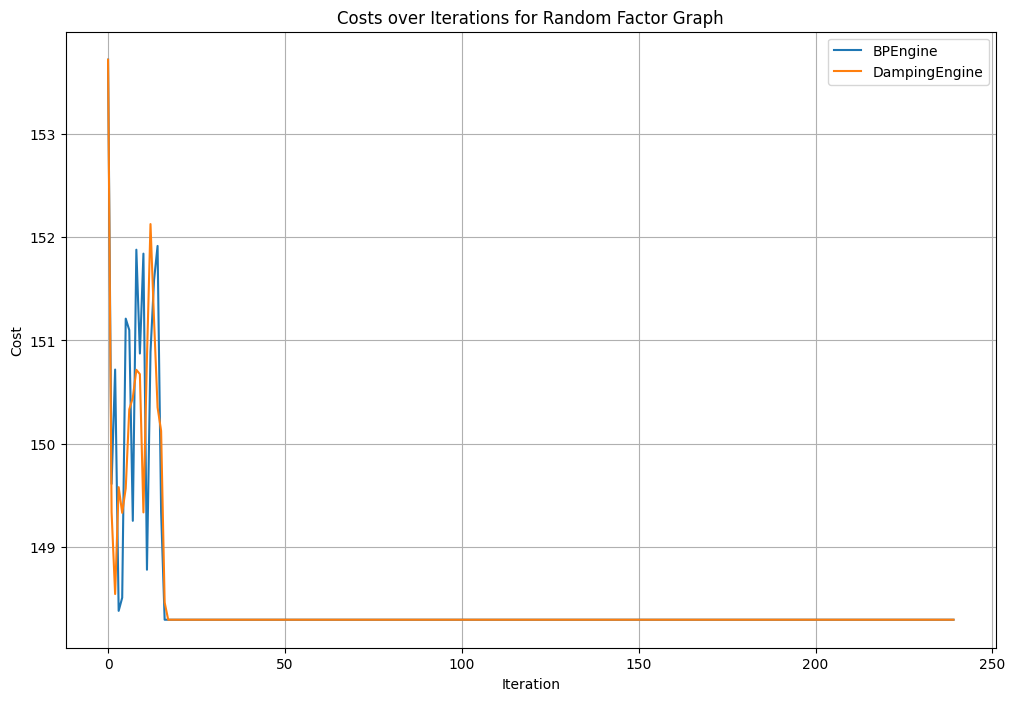

In [7]:
def plot_results(results, title):
    """
    Plot the costs over iterations for each engine.
    
    Args:
        results (dict): Dictionary mapping engine names to their costs over iterations
        title (str): Title for the plot
    """
    plt.figure(figsize=(12, 8))
    
    for engine_name, costs in results.items():
        # Skip the first 5 costs (initial random costs)
        max_len = max(len(c) for c in costs)
        costs = [c + [c[-1]] * (max_len - len(c)) for c in costs]
        plt.plot(np.average(np.array(costs), axis=0), label=engine_name)
    
    plt.title(title)
    plt.xlabel('Iteration')
    plt.ylabel('Cost')
    plt.legend()
    plt.grid(True)
    plt.show()



# Plot results for random factor graph
plot_results(random_results, "Costs over Iterations for Random Factor Graph")


## Verify Damping Functionality

Let's create a specific test to verify that the damping functionality works correctly after each step.


In [6]:
def test_damping(factor_graph, damping_factor=0.9, steps=3):
    """
    Test that damping works correctly after each step.
    
    Args:
        factor_graph (FactorGraph): The factor graph to test on
        damping_factor (float): The damping factor to use
        steps (int): Number of steps to run
        
    Returns:
        list: List of messages before and after damping for each step
    """
    # Create a damping engine
    engine = DampingEngine(factor_graph=factor_graph, damping_factor=damping_factor)
    
    # Run a few steps and capture messages before and after damping
    results = []
    
    for i in range(steps):
        print(f"Step {i+1}:")
        
        # Capture messages before damping
        before_messages = {}
        for var in engine.var_nodes:
            var.compute_messages()
            before_messages[var.name] = [msg.data.copy() for msg in var.mailer.outbox]
        
        # Apply damping
        engine.post_var_compute()
        
        # Capture messages after damping
        after_messages = {}
        for var in engine.var_nodes:
            after_messages[var.name] = [msg.data.copy() for msg in var.mailer.outbox]
        
        # Verify damping was applied correctly
        for var_name in before_messages:
            for j, (before, after) in enumerate(zip(before_messages[var_name], after_messages[var_name])):
                # Check if damping was applied correctly
                # The damped message should be a weighted average of the original message and the incoming message
                print(f"  Variable {var_name}, Message {j}:")
                print(f"    Before damping: {before}")
                print(f"    After damping: {after}")
                
                # Complete the step
                var = next(v for v in engine.var_nodes if v.name == var_name)
                var.empty_mailbox()
                var.mailer.send()
                var.mailer.prepare()
        
        # Complete the step for factors
        for factor in engine.graph.G.nodes():
            factor.compute_messages()
            factor.empty_mailbox()
            factor.mailer.send()
            factor.mailer.prepare()
        
        results.append((before_messages, after_messages))
    
    return results

# Test damping on a small cycle factor graph
small_fg = create_factor_graph(
    graph_type="cycle",
    num_vars=3,
    domain_size=2,
    ct_factory="random_int",
    ct_params={"low": 1, "high": 10}
)

print("Testing damping functionality...")
damping_results = test_damping(small_fg)


ValueError: Unknown graph type: cycle

## Conclusion

This notebook demonstrates how to create factor graphs on the spot with a specified seed and run simulations with them. We've also verified that the damping functionality works correctly after each step.

Key points:
1. Setting a random seed ensures reproducibility of the factor graphs and simulation results.
2. The fixed damping implementation correctly applies damping after each variable computation step.
3. Different engines show different convergence behaviors on the same factor graph.